<a href="https://colab.research.google.com/github/nazianafis/StackOverflow-Data-Analysis/blob/main/StackOverflow_Survey_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Stack Overflow Survey Data 2020**
(Check out my related Medium blog [here.](https://nazianafis.medium.com/best-country-to-work-in-2020-15a790b00904))



In this project I will be analyzing the **Stack Overflow Annual Developer Survey 2020** data. The main survey results are in *survey_results_public.csv*, you can download it directly from Stack Overflow [here](https://insights.stackoverflow.com/survey).

For this analysis I will be focusing on the following three questions:

### **Questions:**

1. Which country provides the highest job satisfaction for developers?

2. Is there a difference in job satisfaction between developers who had an IT related undergraduate major and those who didn’t?

3. Do developers from non IT backgrounds think differently about the importance of having a formal education, such as a university degree in Computer Science, for their career?


---



### **Step 1 : Data Acquisition & Preparation**

In [1]:
!git clone https://github.com/nazianafis/StackOverflow-Data-Analysis.git

Cloning into 'StackOverflow-Data-Analysis'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 124 (delta 62), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (124/124), 8.98 MiB | 10.28 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('/content/StackOverflow-Data-Analysis/survey_results_public.csv')
data.head

<bound method NDFrame.head of        Respondent  ...      YearsCodePro
0               1  ...                27
1               2  ...                 4
2               3  ...               NaN
3               4  ...                 4
4               5  ...                 8
...           ...  ...               ...
64456       64858  ...  Less than 1 year
64457       64867  ...               NaN
64458       64898  ...               NaN
64459       64925  ...               NaN
64460       65112  ...               NaN

[64461 rows x 61 columns]>

The dataset contains 64461 rows and 61 columns.

In [3]:
# Filter data so that it only contains respondents who identify as 'developer'
developer_data = data[data['MainBranch'] == 'I am a developer by profession']

# Fill the NA values in 'JobSat' column with the mode
developer_data['JobSat'] = developer_data['JobSat'].fillna(developer_data['JobSat'].mode()[0])

# Fill the NA values in 'NEWEdImpt' column with the mode
developer_data['NEWEdImpt'] = developer_data['NEWEdImpt'].fillna(developer_data['NEWEdImpt'].mode()[0])


# Fill the NA values in 'ConvertedComp' column with the mean of each country
salary_per_country = developer_data.groupby('Country')['ConvertedComp'].mean()
developer_data['ConvertedComp'] = developer_data.fillna(lambda x: salary_per_country[x['Country']] if pd.isnull(x['ConvertedComp']) else x['ConvertedComp'], axis=1)
developer_data = developer_data.dropna(subset=['ConvertedComp'])

# Set 'JobSat' and 'NEWEdImpt' columns into categorical datatype so that they will be sorted with the right order (ordinal data)
developer_data['JobSat'] = pd.Categorical(developer_data['JobSat'], categories=['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied','Very satisfied'], ordered=True)

developer_data['NEWEdImpt'] = pd.Categorical(developer_data['NEWEdImpt'], categories=['Not at all important/not necessary','Somewhat important','Fairly important','Very important','Critically important'], ordered=True)

developer_data.head

<bound method NDFrame.head of        Respondent                      MainBranch  ... YearsCode      YearsCodePro
0               1  I am a developer by profession  ...        36                27
1               2  I am a developer by profession  ...         7                 4
3               4  I am a developer by profession  ...         7                 4
5               6  I am a developer by profession  ...         6                 4
6               7  I am a developer by profession  ...         6                 4
...           ...                             ...  ...       ...               ...
64154       65631  I am a developer by profession  ...         5  Less than 1 year
64155       65632  I am a developer by profession  ...       NaN               NaN
64157       65634  I am a developer by profession  ...       NaN               NaN
64158       65635  I am a developer by profession  ...         6  Less than 1 year
64159       65636  I am a developer by profession  ...   

The subset only contains 47193 rows.

So far, I have done the following tasks:

* I **filtered** the data so that it contains only those respondents who identify as 'developer'.
* I set the *JobSat* and *NEWEdImpt* columns to categorical datatype.
* Because *JobSat* and *NEWEdImpt* columns contain categorical data, I filled their empty cells with the respective **mode** values.
* Because salaries depend on the country the developer lives in, I filled all NA values in *ConvertedComp* with the respective **mean** salary of developer's country.
* There were still some empty values in *ConvertedComp* column since the mean *ConvertedComp* value for some countries was equal to NaN (i.e. all of the respondents from those countries hadn’t answered the salary question). So I **dropped** those records.

---




### **Step 2 : Data Exploration**

**1. Countries with the Highest Job Satisfaction Rates for Developers**

In [4]:
# Filter the data so that it only contains the survey result from top 20 countries based on the number of total respondents
top_20_countries = list(developer_data['Country'].value_counts().head(20).index)
filtered_developer_data = developer_data[developer_data['Country'].isin(top_20_countries)]

# Aggregate the data so we can visualize it later
aggregated_data = filtered_developer_data.groupby(['Country','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_country = filtered_developer_data['Country'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data.apply(lambda x: x['Respondent'] / total_respondents_per_country[x['Country']], axis=1).round(3)

# Pivot the data
aggregated_data = aggregated_data[['Country', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Country', columns='JobSat').sort_values('Very satisfied', ascending=False)

Because the survey contains data of respondents from more than 180 countries, I narrowed it down to the top 20 based on each country’s total number of respondents. This was desirable because now each country in the top 20 had at least 400 respondents (which was a good enough number for my analysis).

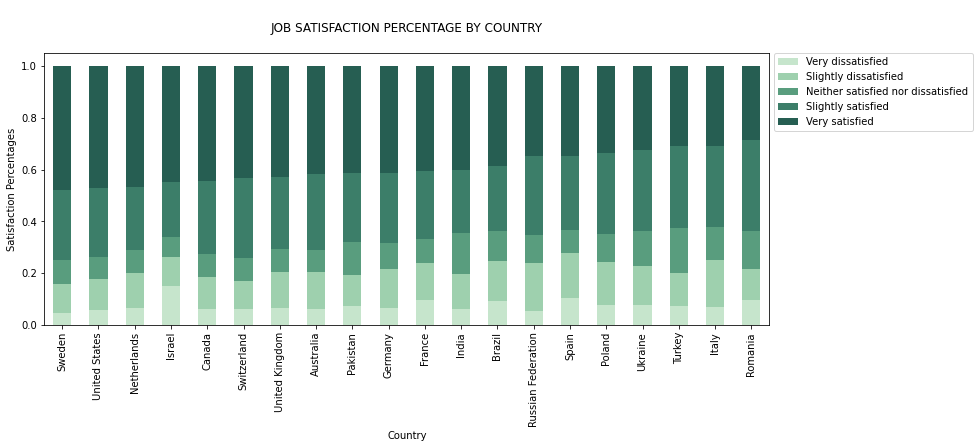

In [5]:
# Visualize the data
pivoted_data.plot(kind='bar',stacked=True,colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.ylabel('Satisfaction Percentages')
plt.title('\nJOB SATISFACTION PERCENTAGE BY COUNTRY\n')
plt.show()

Analysis revealed that Sweden topped the charts, with almost 50% of the developers feeling very satisfied. United States stood second and Netherlands came in third.

**2. Undergraduate Major and Job Satisfaction**


In [6]:
# Create a new column to flag each respondent if their major is related or not
def check_major(value):
    '''
    input: the value of each row in the selected column
    output: the mapped value based on the criteria in this function
    '''

    if value == 'Computer science, computer engineering, or software engineering' or value == 'Information systems, information technology, or system administration' or value == 'Web development or web design':
        return 'IT Related'
    return 'Non IT Related'

developer_data['Major'] = developer_data['UndergradMajor'].apply(check_major)

developer_data['Major'].value_counts(normalize=True)

IT Related        0.652067
Non IT Related    0.347933
Name: Major, dtype: float64

I **split** the *UndergradMajor* column into two — ‘IT Related’ and ‘non IT Related’. Majority of the developers on Stack Overflow (about 65%) had an IT related undergraduate major.

In [7]:
# Aggregate the data so that we know how many respondents are there in each type of major ('IT related' and 'non IT related')
aggregated_data = developer_data.groupby(['Major','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_major = developer_data['Major'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data.apply(lambda x: x['Respondent'] / total_respondents_per_major[x['Major']], axis=1).round(4)

# Pivot the data
aggregated_data = aggregated_data[['Major', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Major', columns='JobSat')

Then I calculated the percentages of each value in *JobSat* to measure job satisfaction for each type of major.

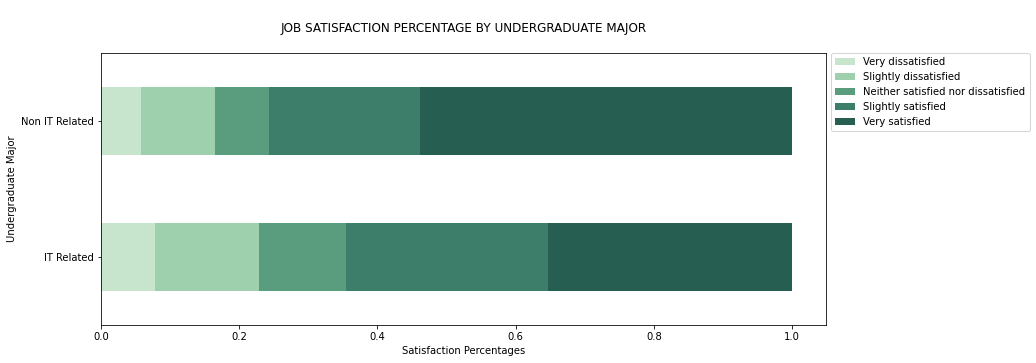

In [8]:
# Visualize the data
pivoted_data.plot(kind='barh',stacked=True,colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.xlabel('Satisfaction Percentages')
plt.ylabel('Undergraduate Major')
plt.title('\nJOB SATISFACTION PERCENTAGE BY UNDERGRADUATE MAJOR\n')
plt.show()

In [9]:
pivoted_data

JobSat          Very dissatisfied  ...  Very satisfied
Major                              ...                
IT Related                 0.0775  ...          0.3537
Non IT Related             0.0585  ...          0.5378

[2 rows x 5 columns]

I found that developers whose undergraduate major is ‘non IT related’ have better job satisfaction as compared those who have an ‘IT related’ background, with 53% and 35% respondents feeling very satisfied respectively.

**3. Importance of Formal Education**

In [10]:
# Aggregate the data to know the number of respondents in each type of major ('IT related' / 'Non IT related')
aggregated_data = developer_data.groupby(['Major','NEWEdImpt'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_major = developer_data['Major'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data.apply(lambda x: x['Respondent'] / total_respondents_per_major[x['Major']], axis=1).round(4)

# Pivot the data
aggregated_data = aggregated_data[['Major', 'NEWEdImpt', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Major', columns='NEWEdImpt')

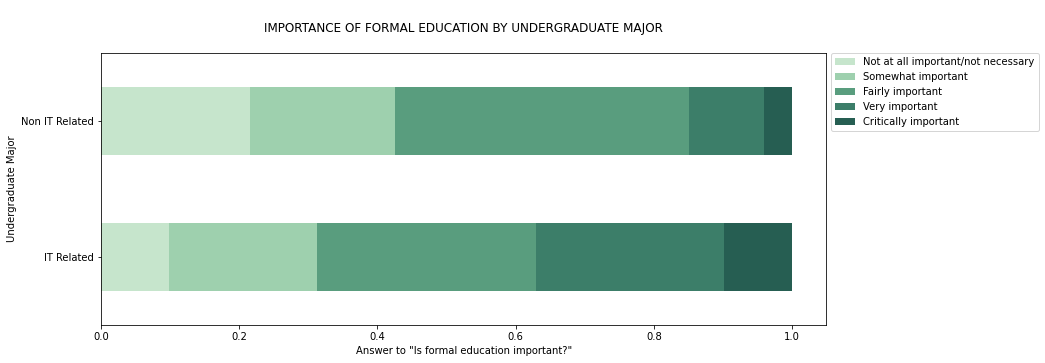

In [11]:
# Visualize the data
pivoted_data.plot(kind='barh',stacked=True,colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.xlabel('Answer to "Is formal education important?"')
plt.ylabel('Undergraduate Major')
plt.title('\nIMPORTANCE OF FORMAL EDUCATION BY UNDERGRADUATE MAJOR\n')
plt.show()


Analysis revealed that developers with IT related backgrounds agreed more with the importance of having a formal education, such as a university degree in Computer Science, for their career. The opposite was true for non IT background developers.



---


### **Conclusion**

Here is a quick summary of my analysis of the Stack Overflow Annual Developer Survey 2020 data:

1.     I measured job satisfaction levels for each country and found that Sweden topped the charts. United States stood second and Netherlands came in third.
2. I looked at undergraduate majors and found that developers from non IT backgrounds had better job satisfaction.
3. I found that developers from non IT fields believed that having a formal education was not as important for their career. Their belief was backed up by the fact that despite not having a background in IT, these respondents were not only working as developers but also had higher job satisfaction.


---